# This Notebook Trains the custom model from scratch on "best-artworks-of-all-time" dataset and then use this trained model for style transfer algorithm  

### Most of the code resembles with the "fine-tuned-VGG16-styleTransfer.ipynb", so I have added the comments wherever the changes occurred

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import os
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from collections import namedtuple
from torchvision import transforms, models, datasets
from PIL import Image
from collections import OrderedDict
from torchvision.transforms.functional import to_tensor
!pip install torchsummary



### Few considerations
> Adjust the root_dir for the dataset

> Adjust the artists directory for the csv file of dataset

> add monalisa path (given in repo) or any other content image in place of monnalisa variable

In [30]:
root_dir = '/kaggle/input/best-artworks-of-all-time/images/images/'
artists = pd.read_csv('/kaggle/input/best-artworks-of-all-time/artists.csv')
monalisa = '/kaggle/input/monalisa-1/monsalisa.jpg'

## Now, this is the custom model architecture that is the lower version of the VGG. Now onwars, we will train our model from the scratch

In [5]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Define a custom dataset class
class ArtDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_labels = dataframe['class_label']
        self.image_paths = dataframe['images_path']
            

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        class_label = self.class_labels[idx]

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, class_label

import torch.nn as nn
import torch.nn.init as init

class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomModel, self).__init__()

        # Define the convolutional feature extraction layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Global average pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        # Define the fully connected classifier layers
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, num_classes),
            nn.Softmax(dim=1)
        )

        # Initialize weights using Xavier initialization
        self.apply(self.init_weights)

    def init_weights(self, m):
        # Initialize weights of convolutional and linear layers using Xavier initialization
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            init.xavier_uniform_(m.weight)
            if m.bias is not None:
                # Initialize biases to zero
                init.constant_(m.bias, 0)
        # Initialize weights of batch normalization layers
        elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
            init.constant_(m.weight, 1)
            init.constant_(m.bias, 0)

    def forward(self, x):
        features = []   # store features to use it further in style transfer algorithm (to calculate losses)
        feature_to_store = [1, 8, 15, 22]   #starting convolutions of each block of the CustomModel
        for i, layer in enumerate(self.features):
            x = layer(x)
            if i in feature_to_store:
                features.append(x)      

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        classification = self.classifier(x)  #Classification layer for the training of my feature extractor so that it can be used for the style transfer algorithm 

        return features, classification



cuda


In [6]:
# Load the artists dataset
artists.shape  # Check the shape of the dataset

# Sort artists by the number of paintings in descending order
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]

# Calculate class weights for each artist based on the number of paintings
# The class weight is computed as the total paintings divided by the product of the number of artists and their paintings
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)

# Normalize class weights to ensure they sum up to 1
total_weights = artists_top['class_weight'].sum()
artists_top['class_weight'] = artists_top['class_weight'] / total_weights

# Display the resulting dataframe with artist names, number of paintings, and class weights
artists_top


name  paintings  class_weight
0        Vincent van Gogh        877      0.034239
1             Edgar Degas        702      0.042774
2           Pablo Picasso        439      0.068399
3   Pierre-Auguste Renoir        336      0.089367
4          Albrecht Dürer        328      0.091547
5            Paul Gauguin        311      0.096551
6          Francisco Goya        291      0.103187
7               Rembrandt        262      0.114608
8           Alfred Sisley        259      0.115936
9                  Titian        255      0.117754
10           Marc Chagall        239      0.125638

In [7]:
# Set class weights - assign higher weights to underrepresented classes
class_weights = artists_top['class_weight'].to_dict()
num_classes = len(class_weights)
num_classes

11

In [8]:
# There appears to be an issue with recognizing 'Albrecht_Dürer' (reason unknown, may require investigation)
# To address this, I'm updating the string to be used as a directory name in the dataframe
updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name

In [9]:
# Check if all directories exist
artists_top_name = artists_top['name'].str.replace(' ', '_').values
for name in artists_top_name:
    directory_path = os.path.join(root_dir, name)
    if os.path.exists(directory_path):
        print(f"Found: {directory_path}")
    else:
        print(f"Did not find: {directory_path}")

Found: /kaggle/input/best-artworks-of-all-time/images/images/Vincent_van_Gogh
Found: /kaggle/input/best-artworks-of-all-time/images/images/Edgar_Degas
Found: /kaggle/input/best-artworks-of-all-time/images/images/Pablo_Picasso
Found: /kaggle/input/best-artworks-of-all-time/images/images/Pierre-Auguste_Renoir
Found: /kaggle/input/best-artworks-of-all-time/images/images/Albrecht_Dürer
Found: /kaggle/input/best-artworks-of-all-time/images/images/Paul_Gauguin
Found: /kaggle/input/best-artworks-of-all-time/images/images/Francisco_Goya
Found: /kaggle/input/best-artworks-of-all-time/images/images/Rembrandt
Found: /kaggle/input/best-artworks-of-all-time/images/images/Alfred_Sisley
Found: /kaggle/input/best-artworks-of-all-time/images/images/Titian
Found: /kaggle/input/best-artworks-of-all-time/images/images/Marc_Chagall


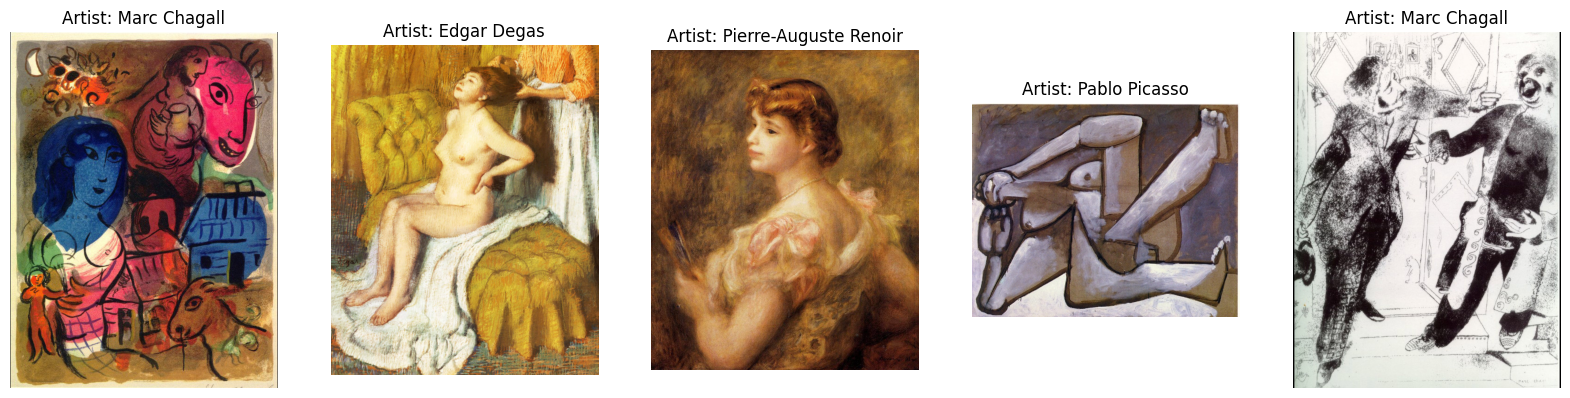

In [10]:
# Display a few random paintings from the dataset
num_paintings_to_display = 5  # Number of paintings to show in the visualization
fig, axes = plt.subplots(1, num_paintings_to_display, figsize=(20, 10))

# Iterate to select random artists and paintings
for i in range(num_paintings_to_display):
    # Randomly choose an artist from the top artists list
    random_artist = random.choice(artists_top_name)
    
    # Randomly select a painting from the chosen artist's directory
    random_image = random.choice(os.listdir(os.path.join(root_dir, random_artist)))
    random_image_file = os.path.join(root_dir, random_artist, random_image)
    
    # Load and display the image
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

In [11]:
def get_dataset(artists_names, dataset_root):
    total_images = []
    train_images = []
    train_labels = []
    val_images = []
    val_labels = []
    
    train_ratio = 0.8

    for class_label, class_name in enumerate(artists_names):
        class_path = os.path.join(dataset_root, class_name)
        
        if os.path.isdir(class_path):
            # Get the list of image paths
            image_paths = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('.jpg', '.jpeg', '.png'))]
            
            # Shuffle the image paths and split into training and validation sets
            random.shuffle(image_paths)
            num_train_images = int(len(image_paths) * train_ratio)
            train_images.extend(image_paths[:num_train_images])
            val_images.extend(image_paths[num_train_images:])
            total_images.extend(image_paths)
            # Assign class labels for training and validation
            train_labels.extend([class_label] * num_train_images)
            val_labels.extend([class_label] * (len(image_paths) - num_train_images))

    train_df = pd.DataFrame({'images_path': train_images, 'class_label': train_labels})
    val_df = pd.DataFrame({'images_path': val_images, 'class_label': val_labels})
    
    return train_df, val_df, total_images

def get_mean_sig(total_images):
    

    # Assuming total_images is a list of PIL images
    total_images = [Image.open(img_t).convert('RGB') for img_t in total_images]

    # Resize images in parallel
    total_images = [transforms.Resize((224, 224))(img_t) for img_t in total_images]

    # Convert images to tensors in parallel
    total_tensors = [to_tensor(img_t) for img_t in total_images]

    # Stack the tensors along a new dimension (dim=3)
    imgs = torch.stack(total_tensors, dim=3)

    # Calculate mean and standard deviation in parallel
    mean_values = imgs.view(3, -1).mean(dim=1)
    std_values = imgs.view(3, -1).std(dim=1)

    print("Mean values:", mean_values)
    print("Standard deviation values:", std_values)
    return mean_values, std_values


In [12]:
# Create training and validation datasets
train_df, val_df, total_images = get_dataset(artists_top_name, root_dir)

## Finding the mean and std for our custom datasets

In [13]:
# mean_values, std_values = get_mean_sig(total_images)  #Finding mean and std for my custom dataset
mean_values = [0.4988, 0.4514, 0.3807]    #can be found by uncommenting and triggering the above function
std_values = [0.2689, 0.2623, 0.2611]

In [14]:
print(mean_values)
print(std_values)

[0.4988, 0.4514, 0.3807]
[0.2689, 0.2623, 0.2611]


In [15]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from PIL import Image
import torch.cuda
from torch.optim.lr_scheduler import StepLR
# Empty the GPU cache
torch.cuda.empty_cache()

# Augmentation transformations for better generalization of the model
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Randomly crop and resize
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Color jitter
    transforms.RandomRotation(degrees=10),  # Random rotation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=0.1),  # Random affine transformations
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=mean_values, 
                             std=std_values),  # Normalize     
])

# Custom transform for validation images
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_values, 
                             std=std_values),
])

# Create training and validation datasets
train_dataset = ArtDataset(train_df, transform=train_transform)
val_dataset = ArtDataset(val_df, transform=val_transform)

# Create training and validation dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# Initialize the fine-tuned model and move it to the GPU
fine_tuned_model = CustomModel(num_classes).to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss(weight = torch.tensor(list(class_weights.values()))).to(device)

# Define the optimizer (you may need to adjust the learning rate)
optimizer = optim.SGD(fine_tuned_model.parameters(), lr=0.005, momentum=0.9)
# optimizer = optim.Adam(fine_tuned_model.parameters(), lr=0.001)

# Define the scheduler
# scheduler = CosineAnnealingLR(optimizer, T_max=len(train_dataloader), eta_min=0.0005)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


In [16]:
#Print the summary of the model
from torchsummary import summary
summary(fine_tuned_model, (3, 224, 224), device = 'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

In [17]:
from tqdm import tqdm
from sklearn.metrics import f1_score
train_losses = []
val_losses = []
def train_one_epoch(model, dataloader, optimizer, criterion, device, class_weights):
    """
    Train the model for one epoch.

    Args:
        model (nn.Module): The model to be trained.
        dataloader (DataLoader): The training dataloader.
        optimizer (torch.optim.Optimizer): The optimizer for updating model parameters.
        criterion (torch.nn.Module): The loss function.
        device (torch.device): The device on which to perform computations.
        class_weights (torch.Tensor): Class weights for handling class imbalance.

    Returns:
        float: Average training loss for the epoch.
    """
    model.train()
    epoch_loss = 0.0
    all_labels = []
    all_predictions = []

    with tqdm(dataloader, desc='Training', unit='batch', leave=False) as pbar:
        for batch in pbar:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            _, outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Convert outputs to predicted labels
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            pbar.set_postfix({'Training Loss': epoch_loss / len(pbar)})
#     print("pred Truth Labels:", all_predictions)

    # Calculate F1 score for each class
    f1_per_class = f1_score(all_labels, all_predictions, average=None)
    f1_weighted = f1_score(all_labels, all_predictions, average='weighted')

    print("F1 score train for each class:")
    for class_idx, f1_class in enumerate(f1_per_class):
        print(f"Class {class_idx}: {f1_class:.4f} ", end="")
    print(f"\nWeighted F1 score: {f1_weighted:.4f}\n")

    return epoch_loss / len(dataloader)

def validate(model, dataloader, criterion, device):
    """
    Validate the model on the validation set.

    Args:
        model (nn.Module): The model to be validated.
        dataloader (DataLoader): The validation dataloader.
        criterion (torch.nn.Module): The loss function.
        device (torch.device): The device on which to perform computations.

    Returns:
        float: Average validation loss for the epoch.
    """
    model.eval()
    epoch_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            _, outputs = model(images)
            loss = criterion(outputs, labels)

            epoch_loss += loss.item()

            # Convert outputs to predicted labels
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate F1 score for each class
    f1_per_class = f1_score(all_labels, all_predictions, average=None)
    f1_weighted = f1_score(all_labels, all_predictions, average='weighted')

    print("F1 score val for each class:")
    for class_idx, f1_class in enumerate(f1_per_class):
        print(f"Class {class_idx}: {f1_class:.4f} ", end="")
    print(f"\nWeighted F1 score: {f1_weighted:.4f}\n")

    return epoch_loss / len(dataloader)

def train():
    """
    Main training loop.

    Performs training and validation for multiple epochs, saving the best model based on validation loss.
    """
    # Training and validation loops
    num_epochs = 40

    best_val_loss = float('inf')  # Initialize with a large value
    fine_tuned_model.load_state_dict(torch.load('/kaggle/working/best_custom_model.pth')['model_state_dict'])
    for epoch in range(num_epochs):
        # Training
        train_loss = train_one_epoch(fine_tuned_model, train_dataloader, optimizer, criterion, device, class_weights)
        train_losses.append(train_loss)

        # Validation
        val_loss = validate(fine_tuned_model, val_dataloader, criterion, device)
        val_losses.append(val_loss)

        print(f'Training - Epoch [{epoch+1}/{num_epochs}], Train_loss: {train_loss:.4f}, Val_loss: {val_loss:.4f}')

        # Save the model if the current validation loss is the best so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': fine_tuned_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
            }, 'custom_model_{}.pth'.format(epoch))


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Its time to train it

In [3]:
train()

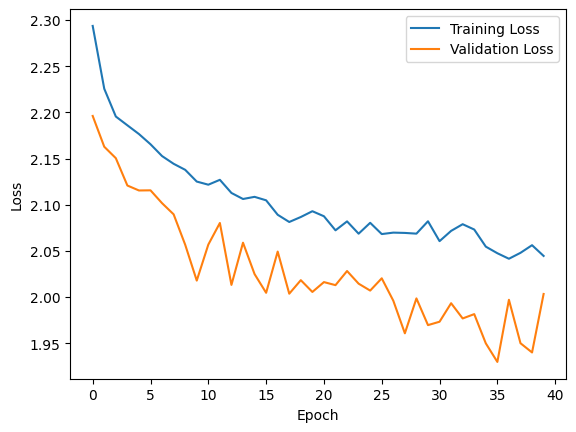

40

In [19]:
# Plot the training loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
len(val_losses)

In [ ]:
import torchvision
# print('Classification Report:')
# print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists_top_name.tolist()))

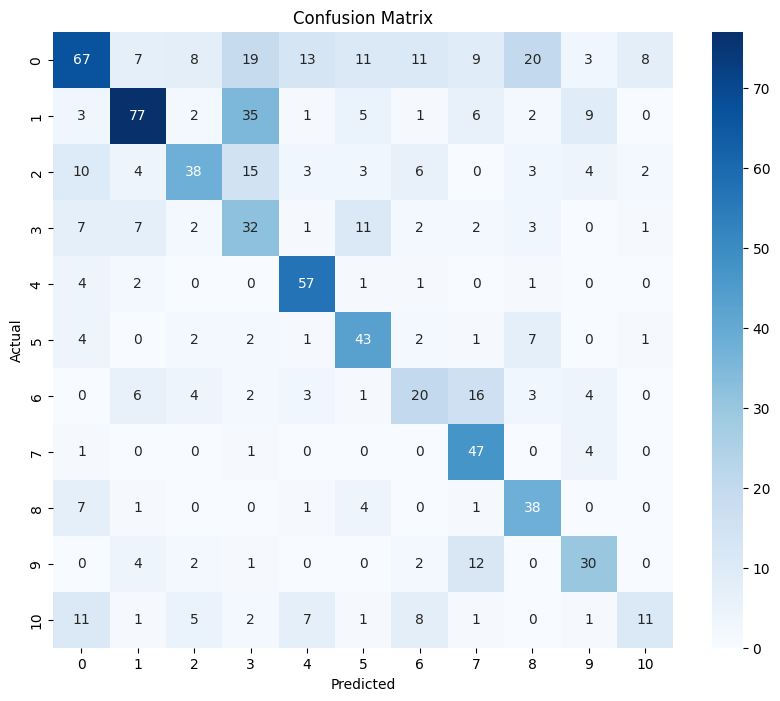

F1 score for each class:
Class 0: 0.4621
Class 1: 0.6160
Class 2: 0.5033
Class 3: 0.3616
Class 4: 0.7451
Class 5: 0.6014
Class 6: 0.3571
Class 7: 0.6351
Class 8: 0.5891
Class 9: 0.5660
Class 10: 0.3099
Overall Weighted F1 Score: 0.5240


In [20]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, dataloader, criterion, device):
    """
    Evaluate the trained model on the validation set.

    Args:
        model (nn.Module): The trained model to be evaluated.
        dataloader (DataLoader): The validation dataloader.
        criterion (torch.nn.Module): The loss function.
        device (torch.device): The device on which to perform computations.

    Prints:
        Confusion matrix, F1 score for each class, and overall weighted F1 score.
    """
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in val_dataloader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            _, outputs = model(images)

            # Convert outputs to predicted labels
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate F1 score for each class
    f1_per_class = f1_score(all_labels, all_predictions, average=None)

    print("F1 score for each class:")
    for class_idx, f1_class in enumerate(f1_per_class):
        print(f"Class {class_idx}: {f1_class:.4f}")

    # Calculate overall F1 score
    overall_f1 = f1_score(all_labels, all_predictions, average='weighted')
    print(f"Overall Weighted F1 Score: {overall_f1:.4f}")

# Assuming num_classes is defined somewhere in your code
num_classes = 10  # Change this to the actual number of classes

# Call the evaluate_model function after training
# fine_tuned_model.load_state_dict(torch.load('/kaggle/working/best_custom_model.pth'))
evaluate_model(fine_tuned_model, val_dataloader, criterion, device)

In [18]:
# Function to load and preprocess an image
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_values, 
                             std=std_values)])
    return transform(image).unsqueeze(0)

# Function to display an image
def imshow(tensor, title=None):
    image = tensor
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def get_inputs(content_path, artist):
    # Load content and style images
    content_image = load_image(content_path)
    # random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(root_dir, artist)))
    style_path = os.path.join(root_dir, artist, random_image)

    # Load content and style images
    style_image = load_image(style_path)

    # Display content and style images
    plt.imshow(Image.open(content_path).convert('RGB'))
    # plt.title(title)
    plt.pause(0.001)
    plt.imshow(Image.open(style_path).convert('RGB'))

    # plt.title(title)
    plt.pause(0.001)
    plt.show()
    # torchvision.utils.save_image(Image.open('/kaggle/input/tttttt/download.jpg'), 'output}.png')
    return content_image, style_image

In [19]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 


# This is a Style Transfer Algorithm

### Make sure to change the fine_tuned file path accordingly as given in github repo

In [34]:
chk = '/kaggle/input/custom/custom_model_35.pth'
# chk = './scratch_weights/custom_model_35.pth'
def style_transfer(config):
    # Define weights for different layers in the style image
    style_weights = {
        '1': 1,
        '8': .7,
        '15': .2,
        '25': .2
    }

    # Image preprocessing
    # We use the same normalization statistics here.
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_values, 
                             std=std_values)])
    
    # Load content and style images
    # Make the style image the same size as the content image
    content = config['content']
    style = config['style']
    
    # Initialize a target image with the content image
    target = content.clone().requires_grad_(True)
    content = content
    style = style
    
    # Initialize an Adam optimizer for updating the target image
    optimizer = torch.optim.Adam([target], lr=config['lr'])
    
    # Load the fine-tuned model
    fine_tuned_model.load_state_dict(torch.load(chk)['model_state_dict'])
    vgg = fine_tuned_model.eval()  # Set the model to evaluation mode
    
    style_losses = []
    content_losses = []

    for step in tqdm(range(config['total_step'])):
        # Extract multiple (5) convolutional feature vectors
        target_features, _ = vgg(target.to(device))
        content_features, _ = vgg(content.to(device))
        style_features, _ = vgg(style.to(device))

        style_loss = 0
        content_loss = 0

        for f1, f2, f3 in zip(target_features, content_features, style_features):
            # Compute content loss with target and content images
            content_loss += torch.mean((f1 - f2)**2)
            
            # Compute the style loss
            style_loss = 0

            # Iterate through each layer and compute the style loss
            for i, layer in enumerate(style_weights):
                # Get the "target" style representation for the layer
                target_feature = target_features[i]
                target_gram = gram_matrix(target_feature)
                _, d, h, w = target_feature.shape
                
                # Get the "style" style representation
                style_gram = gram_matrix(style_features[i])
                style_gram = style_gram
                
                # Compute the style loss for one layer, weighted appropriately
                layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
                
                # Add to the style loss
                style_loss += layer_style_loss / (d * h * w)
        
        style_losses.append(style_loss.cpu())
        content_losses.append(content_loss.cpu())
        
        # Compute total loss, backpropagate, and optimize
        loss = config['content_weight'] * content_loss + config['style_weight'] * style_loss 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (step+1) % config['log_step'] == 0:
            print('Step [{}/{}], Content Loss: {:.4f}, Style Loss: {:.4f}'.format(
                step+1, config['total_step'], content_loss.item(), style_loss.item()))
        if (step+1) % config['sample_step'] == 0:
            # Save the generated image
            denorm = transforms.Normalize(mean=[-m/s for m, s in zip(mean_values, std_values)], std=[1/s for s in std_values])
            img = target.clone().squeeze()
            img = denorm(img).clamp_(0, 1)
            imshow(img, title='Generated Image')
#             torchvision.utils.save_image(img, 'output-{}.png'.format(step+1))
    
    return style_losses, content_losses

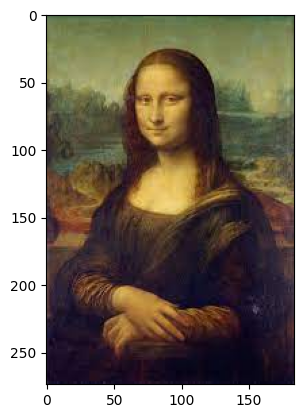

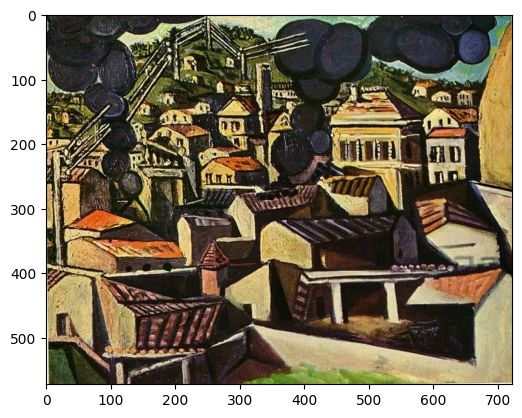

In [27]:
content_image, style_image = get_inputs(monalisa, "Pablo_Picasso")    #Content, Style Image

 25%|██▍       | 399/1600 [00:16<00:48, 24.52it/s]

Step [400/1600], Content Loss: 2.3219, Style Loss: 0.6532


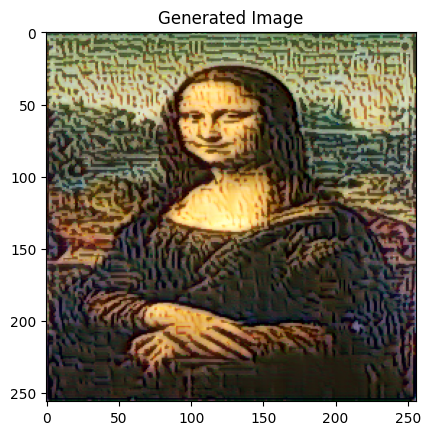

 50%|████▉     | 798/1600 [00:32<00:32, 24.53it/s]

Step [800/1600], Content Loss: 2.4409, Style Loss: 0.1982


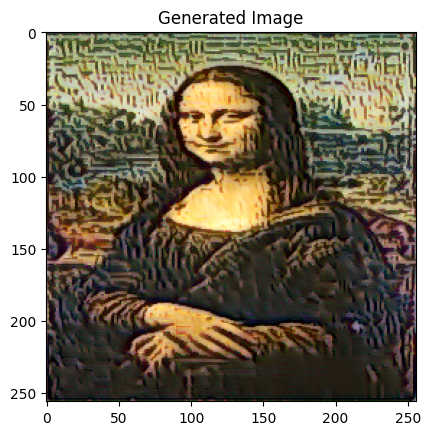

 75%|███████▍  | 1197/1600 [00:49<00:16, 24.47it/s]

Step [1200/1600], Content Loss: 2.4746, Style Loss: 0.1000


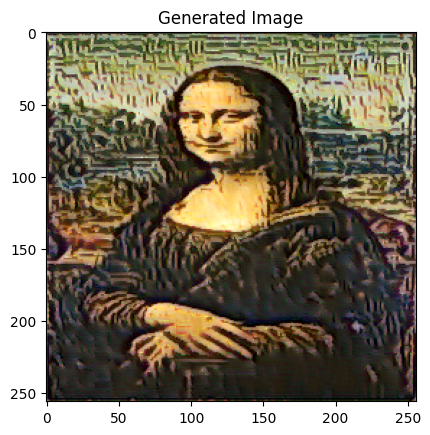

100%|█████████▉| 1599/1600 [01:06<00:00, 24.53it/s]

Step [1600/1600], Content Loss: 2.4896, Style Loss: 0.0621


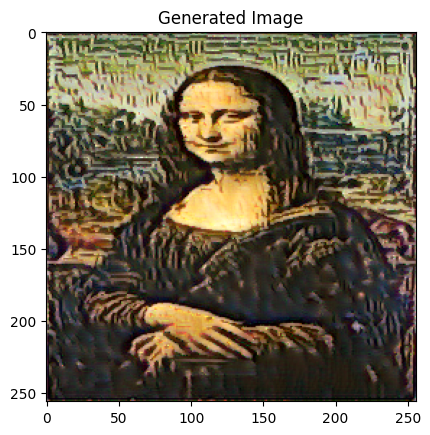

100%|██████████| 1600/1600 [01:06<00:00, 23.95it/s]


In [35]:
import torchvision
config = {
    'content': content_image,
    'style': style_image,
    'max_size': None,
    'total_step': 1600,
    'log_step': 400,
    'sample_step': 400,
    'style_weight': 1e9,
    'content_weight': 1,
    'lr': 0.003,
    
}
style_losses, content_losses = style_transfer(config)

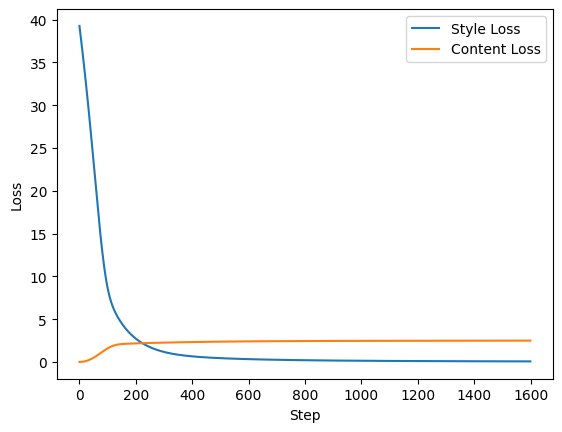

In [36]:
# Plot the style and content loss
plt.plot([style_loss.item() for style_loss in style_losses], label='Style Loss')
plt.plot([content_loss.item() for content_loss in content_losses], label='Content Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()

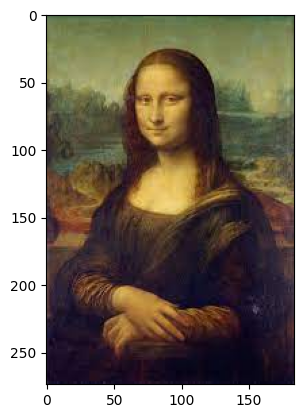

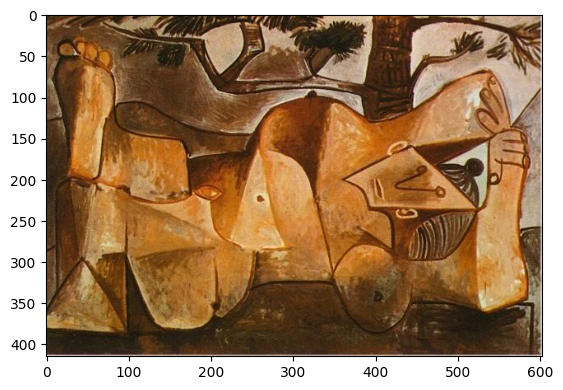

In [38]:
content_image, style_image = get_inputs(monalisa, "Pablo_Picasso")    #Content, Style Image

 25%|██▍       | 399/1600 [00:16<00:49, 24.16it/s]

Step [400/1600], Content Loss: 0.9956, Style Loss: 0.3662


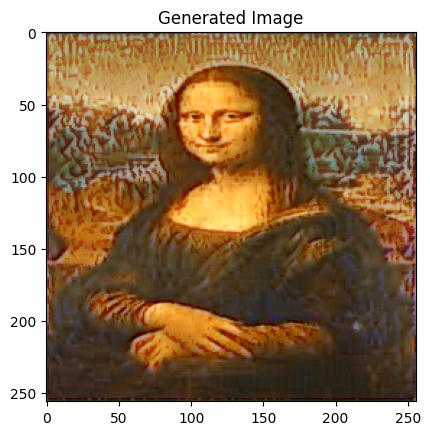

 50%|████▉     | 798/1600 [00:33<00:33, 24.01it/s]

Step [800/1600], Content Loss: 1.0964, Style Loss: 0.0928


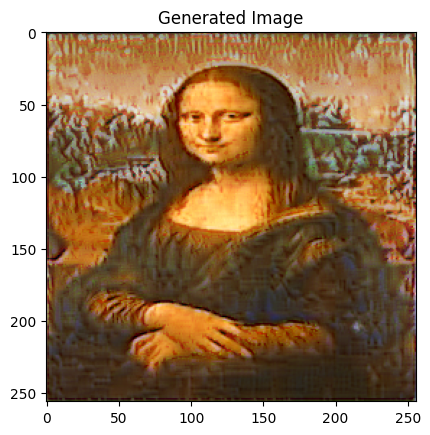

 75%|███████▍  | 1197/1600 [00:50<00:16, 24.20it/s]

Step [1200/1600], Content Loss: 1.1298, Style Loss: 0.0504


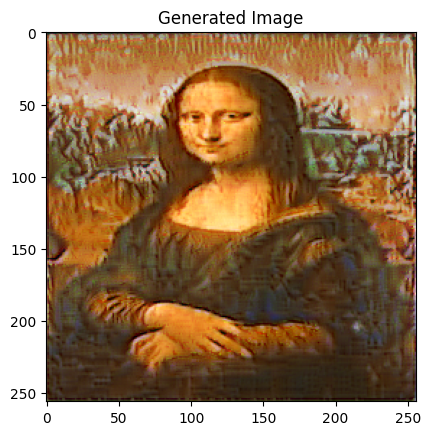

100%|█████████▉| 1599/1600 [01:07<00:00, 24.46it/s]

Step [1600/1600], Content Loss: 1.1549, Style Loss: 0.0316


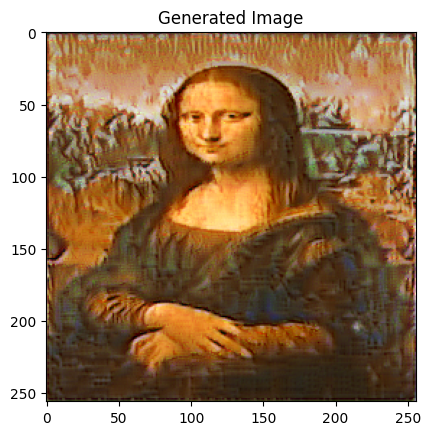

100%|██████████| 1600/1600 [01:07<00:00, 23.63it/s]


In [39]:
import torchvision
config = {
    'content': content_image,
    'style': style_image,
    'max_size': None,
    'total_step': 1600,
    'log_step': 400,
    'sample_step': 400,
    'style_weight': 1e9,
    'content_weight': 1,
    'lr': 0.003,
    
}
style_losses, content_losses = style_transfer(config)

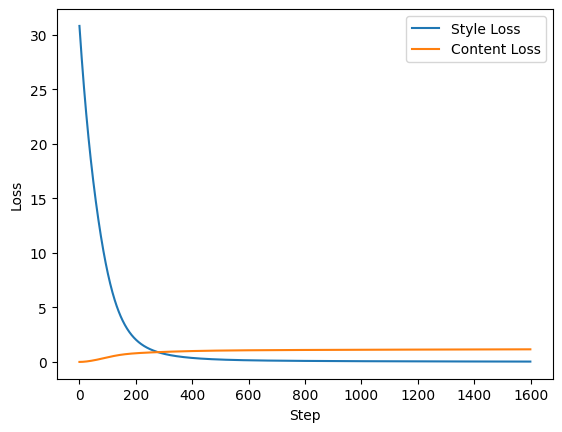

In [41]:
# Plot the style and content loss
plt.plot([style_loss.item() for style_loss in style_losses], label='Style Loss')
plt.plot([content_loss.item() for content_loss in content_losses], label='Content Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()

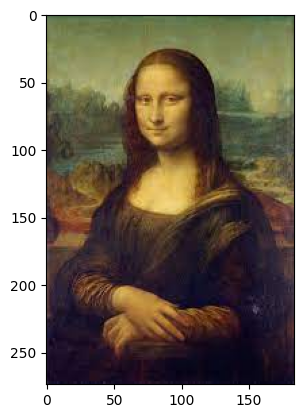

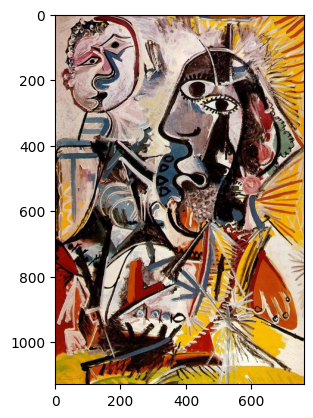

In [45]:
content_image, style_image = get_inputs(monalisa, "Pablo_Picasso")    #Content, Style Image

 25%|██▍       | 399/1600 [00:16<00:48, 24.54it/s]

Step [400/1600], Content Loss: 2.8444, Style Loss: 6.4433


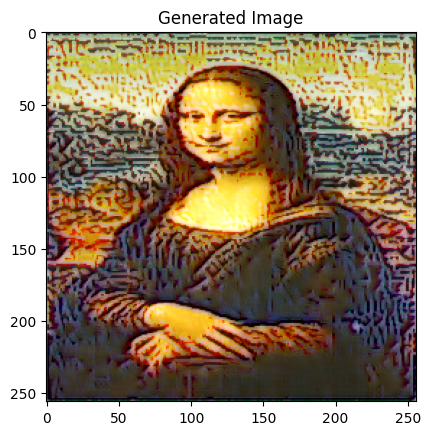

 50%|████▉     | 798/1600 [00:33<00:33, 24.29it/s]

Step [800/1600], Content Loss: 3.1972, Style Loss: 0.7537


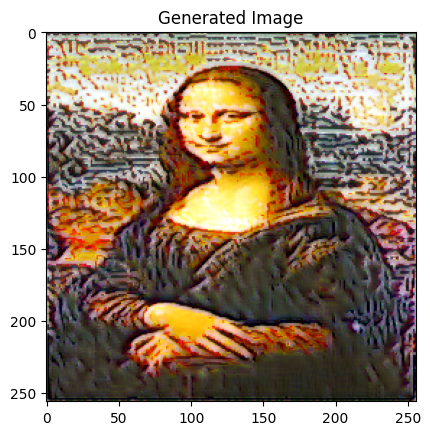

 75%|███████▍  | 1197/1600 [00:50<00:16, 24.28it/s]

Step [1200/1600], Content Loss: 3.2537, Style Loss: 0.3363


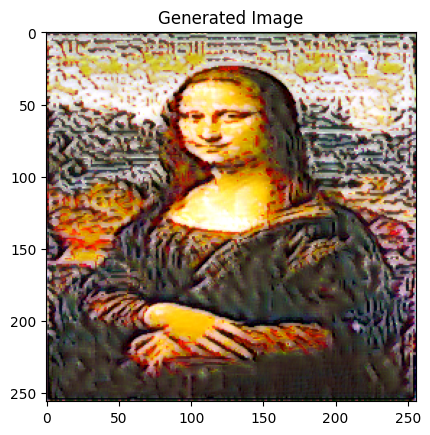

100%|█████████▉| 1599/1600 [01:07<00:00, 24.28it/s]

Step [1600/1600], Content Loss: 3.2690, Style Loss: 0.2006


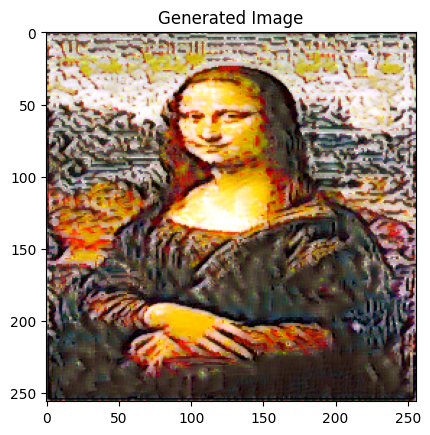

100%|██████████| 1600/1600 [01:07<00:00, 23.70it/s]


In [46]:
import torchvision
config = {
    'content': content_image,
    'style': style_image,
    'max_size': None,
    'total_step': 1600,
    'log_step': 400,
    'sample_step': 400,
    'style_weight': 1e9,
    'content_weight': 1,
    'lr': 0.003,
    
}
style_losses, content_losses = style_transfer(config)

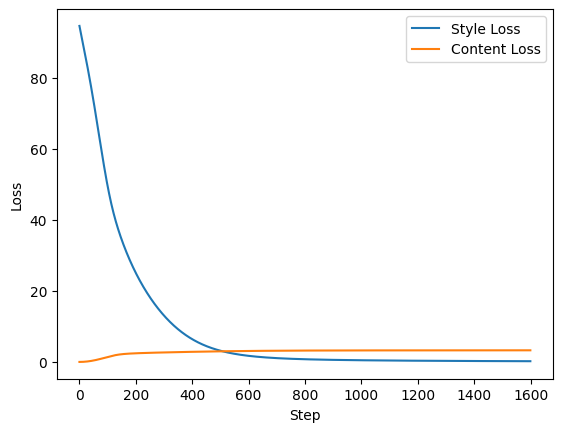

In [47]:
# Plot the style and content loss
plt.plot([style_loss.item() for style_loss in style_losses], label='Style Loss')
plt.plot([content_loss.item() for content_loss in content_losses], label='Content Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Limitations of this model:
1. **Less Diversity in Dataset**
    - Its might be becoming difficult for the model to generalize the feature extractor since the dataset used is less divergent.  

2. **Hyperparameter Control:**
   - The performance of style transfer algorithms is sensitive to hyperparameters, and finding the right set of parameters for a diverse range of content and style pairs can be challenging.
   
3. **High Quality Images:**
   - Generating high-quality images may require significant computational resources and time. Also, we can only generate 224*224 images for this model  
    
## Improvements
1. **VAE Models**
Instead of training it on classification model, VAE Encoder-Decoder model can be used and then further use its trained encoder for your style transfer algorithm
2. **Tuning of Hyper Parameters** 
Further HyperParameter tuning is essentially required for the beeter results.